# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

---

*   62340500002 Kantaka Sirithanarattanakul
*   62340500042 Pakapak Silpapinun
 
---

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [14]:
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import matplotlib as mpl
# mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
# mpl.rc('font', family='TH Sarabun New')
import warnings
warnings.filterwarnings("ignore")

2.12.0


In [15]:
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Layer
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Reshape, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np

import random
from pprint import pprint
from sklearn.model_selection import train_test_split
import os

In [16]:
import csv
with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])
print(len(name_th), len(name_en))

10887 10887


In [17]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

max_th_len = max(len(element) for element in name_th)
max_en_len = max(len(element) for element in name_en)

print('\nMax th length:', max_th_len, '\nMax en length:', max_en_len)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak

Max th length: 20 
Max en length: 19


## Task1: Preprocess dataset for Keras
* 2 dictionaries for indexing (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding)


<font color='red'>Issue (Sea)</font>

+ <font color='red'>เราสร้างไว้ dictionary ไว้แล้ว แต่ไม่แน่ใจว่าควรแยก Dict ตัวอักษร TH กับ Dict ตัวอักษร EN ด้วยไหม</font>

+ <font color='red'>ยังไม่ได้สร้าง special token for the end of word symbol (output)</font>

In [18]:
# FILL YOUR CODE HERE 

# (FON) Create Dictionaries
class LangDict:
    def __init__(self):
        self.char_to_idx = {}
        self.idx_to_char = {}

    def preprocess(self, input:list):
        char =[]
        for i in input:
            for j in i:
                char.append(j)
        # print(char)
        char.insert(0, "<PAD>")     # Special token for padding input
        # char.append("</PAD>")     # Special token for padding output
        char = list(dict.fromkeys(char))
        self.char_to_idx = { ch:i for i,ch in enumerate(char) }
        self.idx_to_char = { i:ch for i,ch in enumerate(char) }
        return self.char_to_idx, self.idx_to_char

th_char = LangDict()
en_char = LangDict()
th_char.preprocess(name_th)
en_char.preprocess(name_en)
# Show
# pprint(idx_to_char)
print('Thai Length:', len(th_char.char_to_idx), len(th_char.idx_to_char))
print('Eng Length:', len(en_char.char_to_idx), len(en_char.idx_to_char))

Thai Length: 65 65
Eng Length: 23 23


In [19]:
#Preprocessing
input_chars = list(set(name_th))
output_chars = list(set(name_en))

vocab_size = len(th_char.char_to_idx)
# +1 for padding
data_size = len(input_chars)
output_vocab_size = len(output_chars)+1

print('There are %d lines and %d unique characters in your input name.' % (data_size, vocab_size))
maxlen = len( max(input_chars, key=len)) #max input length

There are 5904 lines and 65 unique characters in your input name.


# Attention Mechanism


## Task 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* Hint: you will probably need more hidden dimmensions than what you've seen in the demo


In [20]:
from tensorflow.keras.activations import softmax, tanh
from tensorflow.keras.layers import Lambda

def softMaxAxis1(x):
    return softmax(x,axis=1)

def tanhAxis1(x):
    return tanh(x, axis=1)

In [21]:
#These are global variables (shared layers)
## Fill your code here
## you are allowed to use code in the demo as your template. 

m=15000  # #sample
Tx = 20     # size of input 
Ty = 20     # size of output 
n_h = 64 #hidden dimensions for encoder 
n_s = 128 #hidden dimensions for decoder

# repeator = RepeatVector(Tx)
splitter = Lambda(lambda x:tf.split(x, num_or_size_splits=2,axis=2))
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
#Attention function###
fattn_1 = Dense(10, activation = "tanh")
fattn_2 = Dense(1, activation = "relu")
###
activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)


In [22]:
def key_value_attention(h, s_prev):     # a = encoder hidden state, s_prev = decoder hidden states
    #Fill code here
    s_prev = repeator(s_prev)
    key, value = splitter (h)
    concat = concatenator([key, s_prev])
    k_t = Dropout(0.4)(Dense(10, activation = "relu")(concat))
    energies = Dropout(0.4)(Dense(1, activation='tanh')(k_t))
    attention_scores = activator(energies)
    context = Dot(axes = 1)([attention_scores, value])
    #concat = ...key...
    #context = ...value...

    return context, attention_scores, energies # return whatever you need to complete this homework 

## Task3: Create and train your encoder/decoder model here
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [23]:

class HW4Model:
    def __init__(self, n_h, n_s, ratio=0.3):
        """
        Arguments:
        Tx -- length of the input sequence
        Ty -- length of the output sequence
        n_h -- hidden state size of the Bi-LSTM
        n_s -- hidden state size of the post-attention LSTM
        ratio -- split train val ratio
        """
        self.n_h = n_h
        self.n_s = n_s
        self.ratio = ratio
        self.X = None
        self.Y = None
        self.vocab_size = None
        self.machine_vocab_size = None
        self.model_encoder = None
        self.model_decoder = None

    def inference_encoder(self, Tx):

        encoder_LSTM =  Bidirectional(LSTM(self.n_h, return_sequences=True),input_shape=(-1, Tx, self.n_h*2))

        # Define the input of your model
        X = Input(shape=(Tx, self.vocab_size))

        # Encoder Bi-LSTM
        # h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
        h = encoder_LSTM(X)

        model = Model(inputs=[X], outputs=h)
        return model

    def inference_decoder(self, Tx):

        decoder_LSTM_cell = LSTM(self.n_s, return_state = True)              #decoder_LSTM_cell
        output_layer = Dense(self.machine_vocab_size, activation="softmax") #softmax output layer

        # Define hidden state and cell state for decoder_LSTM_Cell
        s0 = Input(shape=(self.n_s,), name='s0')
        c0 = Input(shape=(self.n_s,), name='c0')
        s = s0
        c = c0
        h = Input(shape=(Tx, n_h*2))

        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        h_, attention_scores, energies = key_value_attention(h, s0)
        print('context:',h_)
        print('attention_scores:',attention_scores)
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(h_, initial_state=[s, c])
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)

        model = Model(inputs=[h,s0,c0], outputs=[out,s,c,attention_scores,energies])

        return model
    
    def create_model(self, Tx, Ty):
        X = Input(shape=(Tx, self.vocab_size))
        s0 = Input(shape=(self.n_s,), name='s0')
        c0 = Input(shape=(self.n_s,), name='c0')
        s = s0
        c = c0
        self.model_encoder = self.inference_encoder(Tx)
        self.model_decoder = self.inference_decoder(Tx)
        outputs = list()
        for t in range(Ty):
            out,s,c,attention_scores,energies = self.model_decoder( [self.model_encoder(X), s,c] )

            # Append an output list with the current output
            outputs.append(out)
            #Create model instance
        self.model = Model(inputs=[X,s0,c0], outputs=outputs)
        opt = Adam(learning_rate= 0.01, clipvalue=0.5)
        self.model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    def train_model(self, directory_path, epoch_=0, load_weight=False):
        if (not os.path.exists(directory_path)):
            os.mkdir(directory_path)

        checkpoint_path = "cp-{epoch:03d}.h5"
        if load_weight:
            self.model.load_weights(load_weight)
        # else:
        #     self.model.save_weights(os.path.join(directory_path, checkpoint_path.format(epoch=epochs)))
        epochs=150
        batch_size=100
        s0 = np.zeros((m, n_s))
        c0 = np.zeros((m, n_s))
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(directory_path, checkpoint_path),
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_freq=int(10*(len(self.X)*0.7/batch_size)))
        with tf.device(tf.DeviceSpec(device_type="GPU")):
            history = self.model.fit([self.X, s0, c0], self.Y, 
            initial_epoch = epoch_,
            epochs=epochs, 
            batch_size=batch_size,
            validation_split=self.ratio,
            callbacks=[model_checkpoint_callback])
        return history
    
    def preparedtaset(self, name_th, name_en):
        th_char = LangDict()
        en_char = LangDict()
        th_char.preprocess(name_th)
        en_char.preprocess(name_en)

        self.vocab_size = len(th_char.char_to_idx)
        self.machine_vocab_size = len(en_char.char_to_idx)

        x_data = [[th_char.char_to_idx[char] for char in th] for th in name_th]
        y_data = [[en_char.char_to_idx[char] for char in en] for en in name_en]

        x_data = pad_sequences(x_data, maxlen=20, dtype='int32', padding='pre', value=0.)
        y_data = pad_sequences(y_data, maxlen=20, dtype='int32', padding='pre', value=0.)

        x_data = to_categorical(x_data, len(th_char.char_to_idx))
        y_data = to_categorical(y_data, len(en_char.char_to_idx))

        m = len(x_data)
        self.X = x_data
        self.Y = list(y_data.swapaxes(0,1))
    
    

In [24]:
model = HW4Model(n_h, n_s)
model.preparedtaset(name_th, name_en)

In [25]:
model.create_model(Tx, Ty)

2023-04-27 09:56:16.979498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 09:56:16.981535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 09:56:16.983226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

context: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 64), dtype=tf.float32, name=None), name='dot_3/MatMul:0', description="created by layer 'dot_3'")
attention_scores: KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name=None), name='attention_scores/transpose_1:0', description="created by layer 'attention_scores'")


2023-04-27 09:56:17.583550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 09:56:17.585630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 09:56:17.587348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [26]:
model.train_model("./weight")

Epoch 1/150


2023-04-27 09:56:36.426479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 09:56:36.428651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 09:56:36.430335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - ETA: 0s - loss: 30.0775 - model_4_loss: 0.3060 - model_4_1_loss: 0.3056 - model_4_2_loss: 0.2635 - model_4_3_loss: 0.2899 - model_4_4_loss: 0.3079 - model_4_5_loss: 0.3408 - model_4_6_loss: 0.3880 - model_4_7_loss: 0.4532 - model_4_8_loss: 0.5559 - model_4_9_loss: 0.7033 - model_4_10_loss: 0.9645 - model_4_11_loss: 1.3301 - model_4_12_loss: 1.8450 - model_4_13_loss: 2.5001 - model_4_14_loss: 3.0016 - model_4_15_loss: 3.3113 - model_4_16_loss: 3.3241 - model_4_17_loss: 3.5388 - model_4_18_loss: 3.1756 - model_4_19_loss: 3.1725 - model_4_accuracy: 0.9869 - model_4_1_accuracy: 0.9867 - model_4_2_accuracy: 0.9866 - model_4_3_accuracy: 0.9856 - model_4_4_accuracy: 0.9845 - model_4_5_accuracy: 0.9836 - model_4_6_accuracy: 0.9795 - model_4_7_accuracy: 0.9714 - model_4_8_accuracy: 0.9530 - model_4_9_accuracy: 0.9213 - model_4_10_accuracy: 0.8554 - model_4_11_accuracy: 0.7513 - model_4_12_accuracy: 0.5983 - model_4_13_accuracy: 0.3797 - model_4_14_accura

2023-04-27 09:58:44.154667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 09:58:44.156617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 09:58:44.158163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 162s 689ms/step - loss: 30.0775 - model_4_loss: 0.3060 - model_4_1_loss: 0.3056 - model_4_2_loss: 0.2635 - model_4_3_loss: 0.2899 - model_4_4_loss: 0.3079 - model_4_5_loss: 0.3408 - model_4_6_loss: 0.3880 - model_4_7_loss: 0.4532 - model_4_8_loss: 0.5559 - model_4_9_loss: 0.7033 - model_4_10_loss: 0.9645 - model_4_11_loss: 1.3301 - model_4_12_loss: 1.8450 - model_4_13_loss: 2.5001 - model_4_14_loss: 3.0016 - model_4_15_loss: 3.3113 - model_4_16_loss: 3.3241 - model_4_17_loss: 3.5388 - model_4_18_loss: 3.1756 - model_4_19_loss: 3.1725 - model_4_accuracy: 0.9869 - model_4_1_accuracy: 0.9867 - model_4_2_accuracy: 0.9866 - model_4_3_accuracy: 0.9856 - model_4_4_accuracy: 0.9845 - model_4_5_accuracy: 0.9836 - model_4_6_accuracy: 0.9795 - model_4_7_accuracy: 0.9714 - model_4_8_accuracy: 0.9530 - model_4_9_accuracy: 0.9213 - model_4_10_accuracy: 0.8554 - model_4_11_accuracy: 0.7513 - model_4_12_accuracy: 0.5983 - model_4_13_accuracy: 0.3797 - model_4_1

# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! 
* Task 5: Show your visualization of attention scores on one of your example 

In [27]:
#task 4
#fill your code here
def prep_input(input_list):
    X = []
    for line in input_list:
        temp = []
        for char in line:
            temp.append(th_char.char_to_idx[char])
        X.append(temp)
    X = pad_sequences(X, maxlen=20)
    X = to_categorical(X, len(th_char.char_to_idx))
    
    return X

### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
--> https://drive.google.com/file/d/168J5SPSf4NNKj718wWUEDpUbh8QYZKux/view?usp=share_link

In [28]:
EXAMPLES = ['กัณฐกะ', 'ภคภัค', 'ไพสิฐ', 'บวรศักดิ์', 'วราสิณี']

model.model.load_weights('./weight/cp-099.h5')
# model.load_weights('/content/model_hw4.h5')

x_tests = prep_input(EXAMPLES)
s0_test = np.zeros((len(x_tests), n_s))
c0_test = np.zeros((len(x_tests), n_s))


############## (Choice B) Predict using encoder-decoder models ##############
prediction = list()
hist_attention_scores = []; hist_energies = []

h = model.model_encoder.predict(x_tests)
s = s0_test
c = c0_test

for t in range(Ty):
    out, s,c, attention_scores, energies = model.model_decoder( [h,s,c] )
    prediction.append(out)
    hist_attention_scores.append(attention_scores)
    hist_energies.append(energies)

hist_attention_scores = np.asarray(hist_attention_scores)
hist_attention_scores = np.transpose(hist_attention_scores, (1, 0, 2, 3))
# hist_attention_scores = np.moveaxis(hist_attention_scores, [0, 1])
hist_attention_scores = np.squeeze(hist_attention_scores)

hist_energies = np.asarray(hist_energies)
hist_energies = np.transpose(hist_energies, (1, 0, 2, 3))
# hist_energies = np.moveaxis(hist_energies, [0, 1])
hist_energies = np.squeeze(hist_energies)
#############################################################################

prediction = np.swapaxes(prediction, 0, 1)
prediction = np.argmax(prediction, axis = -1)

print('\nTest\n---------------------')
for j in range(len(prediction)):
    output = "".join([en_char.idx_to_char[int(i)] for i in prediction[j]])
    print(EXAMPLES[j], '=>', output.replace('<PAD>',''))

2023-04-27 10:56:06.007819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 10:56:06.009830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 10:56:06.011397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 847ms/step

Test
---------------------
กัณฐกะ => anchtka
ภคภัค => phakhaphak
ไพสิฐ => phaisit
บวรศักดิ์ => bawonsak
วราสิณี => warrsani


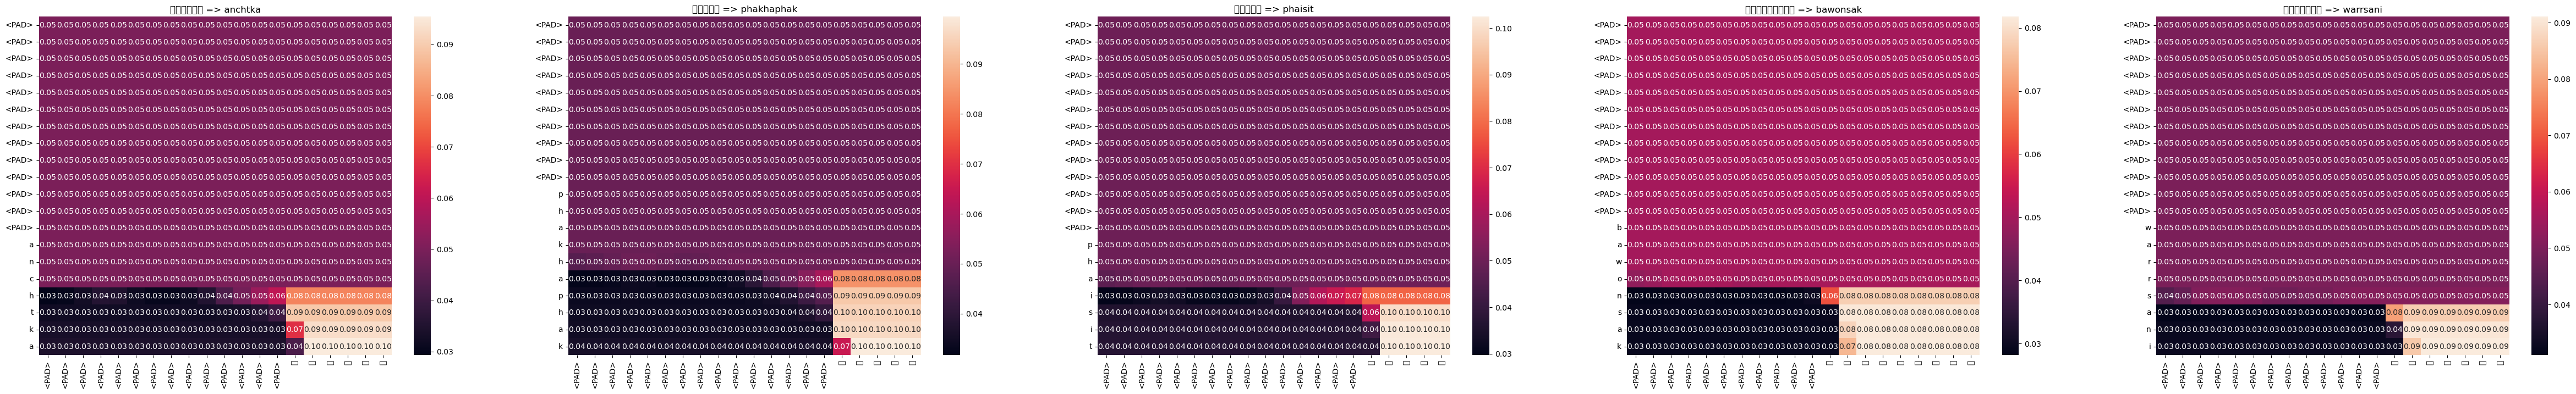

In [30]:
# TASK 5
import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you

fig, ax = plt.subplots(1, 5, figsize=(60,8))
for i in range(len(EXAMPLES)):
    x_axis_labels = [th_char.idx_to_char[idx] for idx in np.argmax(x_tests[i], axis=-1)]
    y_axis_labels = [en_char.idx_to_char[idx] for idx in prediction[i]]

    sns.heatmap(hist_attention_scores[i], annot=True, ax=ax[i], fmt='.2f',
                xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    
    ax[i].set_title(f'{EXAMPLES[i]} => {"".join(y_axis_labels).replace("<PAD>","")}')